In [1]:
import pandas as pd
import scipy.stats as stats
import cianparser # https://github.com/lenarsaitov/cianparser
import distance
from jellyfish import jaro_winkler
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler

In [2]:
# cianparser.parse(
#     deal_type="sale", # "rent_long", "rent_short", "sale"
#     accommodation_type="flat", # "flat", "room", "house", "house-part", "townhouse"
#     location="Санкт-Петербург",
#     rooms=2, # "studio"
#     start_page=1,
#     end_page=100,
#     is_saving_csv=True,
#     is_latin=True,
#     is_express_mode=False,
#     is_by_homeowner=False,)

In [3]:
data = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTulT53cUzDGYyVXhek5ElnmIOoY1KV4NiQajXw0i3-U2DbFENz6ngPWBF16XRZnrgymcwguVk4_Yhc/pub?gid=351372992&single=true&output=csv')

# Предобработка данных(квартиры на продажу в Санкт-Петербурге)

In [4]:
data.head()

,author,author_type,link,city,deal_type,accommodation_type,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters,phone,district,street,underground,residential_complex
0,Петербургская Строительная Компания,developer,https://spb.cian.ru/sale/flat/284740225/,Sankt-Peterburg,sale,flat,1,7,1.0,38.20,419999,16044000,2023,12.0,12.0,7.812218e+10,Petrogradskij,Chkalovskoe,Petrogradskaja,Severnaja Korona
1,Петербургская Строительная Компания,developer,https://spb.cian.ru/sale/flat/280819981/,Sankt-Peterburg,sale,flat,13,25,1.0,36.81,33201,6706674,2024,10.0,13.0,7.812218e+10,Primorskij,Kolomjagi,Prospekt Prosveschenija,Frends ZhK
2,GloraX,developer,https://spb.cian.ru/sale/flat/279507591/,Sankt-Peterburg,sale,flat,5,19,1.0,36.76,265777,9769999,2025,11.0,11.0,7.812213e+10,Vasileostrovskij,Morskoj,Zenit,Gloraks Premium Vasileostrovskij ZhK
3,Группа Эталон,developer,https://spb.cian.ru/sale/flat/285017335/,Sankt-Peterburg,sale,flat,13,18,1.0,32.60,303116,9881582,2022,21.0,-1.0,7.812213e+10,Admiraltejskij,Izmajlovskoe,Moskovskie vorota,Kvartal Galaktika
4,GloraX,developer,https://spb.cian.ru/sale/flat/279351916/,Sankt-Peterburg,sale,flat,11,14,1.0,34.44,322009,11089999,2024,12.0,13.0,7.812213e+10,Krasnogvardejskij,Malaja Ohta,Ladozhskaja,Glorax Zanevskij


In [5]:
data.shape

(7118, 20)

In [6]:
data['flat_id'] = data['link'].str.extract('(\d+)')

In [7]:
data.drop('link', axis = 1,inplace = True)

In [8]:
data.drop(['accommodation_type','deal_type','city'],axis = 1,inplace = True)

In [9]:
n = len(data['author']) // 2
authors1 = data['author'][:n]
authors2 = data['author'][n:]
authors1= authors1.astype('str')
authors2= authors2.astype('str')

In [10]:
distances = authors1.apply(lambda x: authors2.apply(lambda y: jaro_winkler(x,y)))

In [11]:
data.head()

,author,author_type,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters,phone,district,street,underground,residential_complex,flat_id
0,Петербургская Строительная Компания,developer,1,7,1.0,38.20,419999,16044000,2023,12.0,12.0,7.812218e+10,Petrogradskij,Chkalovskoe,Petrogradskaja,Severnaja Korona,284740225
1,Петербургская Строительная Компания,developer,13,25,1.0,36.81,33201,6706674,2024,10.0,13.0,7.812218e+10,Primorskij,Kolomjagi,Prospekt Prosveschenija,Frends ZhK,280819981
2,GloraX,developer,5,19,1.0,36.76,265777,9769999,2025,11.0,11.0,7.812213e+10,Vasileostrovskij,Morskoj,Zenit,Gloraks Premium Vasileostrovskij ZhK,279507591
3,Группа Эталон,developer,13,18,1.0,32.60,303116,9881582,2022,21.0,-1.0,7.812213e+10,Admiraltejskij,Izmajlovskoe,Moskovskie vorota,Kvartal Galaktika,285017335
4,GloraX,developer,11,14,1.0,34.44,322009,11089999,2024,12.0,13.0,7.812213e+10,Krasnogvardejskij,Malaja Ohta,Ladozhskaja,Glorax Zanevskij,279351916


In [12]:
data.drop('phone', axis =1, inplace=True)

In [13]:
data_duplicated_indexes = data[data.duplicated() == True].index

In [14]:
data = data.drop(data_duplicated_indexes, axis =0)

In [15]:
data[['total_meters', 
      'price_per_m2',
      'year_of_construction',
      'living_meters',
      'kitchen_meters']] = data[['total_meters', 'price_per_m2','year_of_construction','living_meters','kitchen_meters']].replace(-1.0, None)

In [16]:
data.isna().sum()

author                    22
author_type               22
floor                      0
floors_count               0
rooms_count                0
total_meters               1
price_per_m2               0
price                      0
year_of_construction     155
living_meters            468
kitchen_meters          1086
district                   0
street                   120
underground              361
residential_complex     2697
flat_id                    0
dtype: int64

In [17]:
data.drop(data[(data.isna().sum(axis=1) >= 4)].index, axis = 0, inplace =True)

In [18]:
data.loc[(data.price_per_m2 <=0),'price_per_m2'] = None 

In [19]:
data.isna().sum()

author                     3
author_type                3
floor                      0
floors_count               0
rooms_count                0
total_meters               1
price_per_m2               1
price                      0
year_of_construction     140
living_meters            433
kitchen_meters          1049
district                   0
street                   120
underground              356
residential_complex     2679
flat_id                    0
dtype: int64

In [20]:
data['author'].fillna(data['author'].mode()[0], inplace =True)
data['author_type'].fillna(data['author_type'].mode()[0], inplace =True)

In [21]:
data[['total_meters',
             'living_meters',
             'kitchen_meters']] = data[['total_meters','living_meters','kitchen_meters']].astype('float64')

In [22]:
data['total_meters'].fillna(data['total_meters'].median(), inplace =True)
data['price_per_m2'].fillna(data['price_per_m2'].median(), inplace =True)

In [23]:
data['year_of_construction'].fillna(data['year_of_construction'].median(), inplace =True)

In [24]:
data['year_of_construction'] = data['year_of_construction'].astype('int64')

In [25]:
data['living_meters'].fillna(data['living_meters'].median(), inplace =True)

In [41]:
data.isna().sum()

author                     0
author_type                0
floor                      0
floors_count               0
rooms_count                0
total_meters               0
price_per_m2               0
price                      0
year_of_construction       0
living_meters              0
kitchen_meters          1049
district                   0
street                   120
underground              356
residential_complex        0
flat_id                    0
dtype: int64

## Заполнение пропусков методом случайного леса
### residential_complex

In [27]:
x_train = data.loc[~data.residential_complex.isna(), ['author','author_type','floor', 'floors_count', 'rooms_count',
       'total_meters', 'price_per_m2', 'price', 'year_of_construction',
       'living_meters', 'district']]
y_train = data.loc[~data.residential_complex.isna(),'residential_complex']
x_test = data.loc[data.residential_complex.isna(), ['author','author_type','floor', 'floors_count', 'rooms_count',
       'total_meters', 'price_per_m2', 'price', 'year_of_construction',
       'living_meters', 'district']]

In [28]:
classes_less_than_5 = y_train.value_counts()[y_train.value_counts() <5].index
sample_strategy = {item: 5 for item in classes_less_than_5}

ROS = RandomOverSampler(sampling_strategy = sample_strategy)
x_train_resampled, y_train_resampled  = ROS.fit_resample(x_train,y_train)

In [29]:
label_encoder = LabelEncoder()
for item in ['author','author_type','year_of_construction','district']:
    x_test[item] = label_encoder.fit_transform(x_test[item])
    x_train_resampled[item] = label_encoder.fit_transform(x_train_resampled[item])

In [46]:
# clf_rf = RandomForestClassifier(random_state=42)
# params = {'criterion':['entropy'],
#           'n_estimators':[45,50], 
#           'max_depth':range(8,11),
#           'min_samples_split':[5,10,20],
#           'min_samples_leaf':[2,5,10],
#           'max_features': ['sqrt']}
# grid_search = GridSearchCV(estimator=clf_rf,
#                            param_grid=params,
#                            cv=StratifiedKFold(n_splits=5, shuffle=True),
#                            n_jobs = -1)
# grid_search.fit(x_train_resampled,y_train_resampled)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
             estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['entropy'], 'max_depth': range(8, 11),
                         'max_features': ['sqrt'],
                         'min_samples_leaf': [2, 5, 10],
                         'min_samples_split': [5, 10, 20],
                         'n_estimators': [45, 50]})

In [47]:
# print(grid_search.best_params_)
# print(grid_search.best_score_)

{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 50}

In [33]:
# residential_complex_pred = grid_search.predict(x_test)
# residential_complex_pred

array(['ID Svetlanovskiy', 'Manufaktura James Beck', "Mir'", ...,
       'Parkolovo', 'Svetlana Park', 'Kompleks apartamentov START'],
      dtype=object)

In [50]:
clf_rf = RandomForestClassifier(criterion='entropy',
                                max_depth= 10,
                                max_features='sqrt',
                                min_samples_leaf=2,
                                min_samples_split=5,
                                n_estimators=50,
                                random_state=42)
clf_rf.fit(x_train_resampled,y_train_resampled)
residential_complex_nonan = clf_rf.predict(x_test)

array(['ID Svetlanovskiy', "Mir'", "Mir'", ..., 'Parkolovo',
       'Monografija ZhK', 'Kompleks apartamentov START'], dtype=object)

In [52]:
residential_complex_nonan.shape

(2679,)

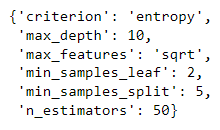

In [34]:
residential_complex_nonan = pd.Series(residential_complex_pred, 
                                      index = data.loc[data.residential_complex.isna(),'residential_complex'].index)
residential_complex_nonan.head()

12                   ID Svetlanovskiy
13             Manufaktura James Beck
19                               Mir'
20    GloraX Premium Vasileostrovskij
77                   Severnaja dolina
dtype: object

In [35]:
data.loc[data.residential_complex.isna(),'residential_complex'] = residential_complex_nonan

### underground

In [54]:
data.isna().sum()

author                     0
author_type                0
floor                      0
floors_count               0
rooms_count                0
total_meters               0
price_per_m2               0
price                      0
year_of_construction       0
living_meters              0
kitchen_meters          1049
district                   0
street                   120
underground              356
residential_complex        0
flat_id                    0
dtype: int64

# EDA

In [37]:
data.describe(include=['int64','float64'])

,floor,floors_count,rooms_count,total_meters,price_per_m2,price,year_of_construction,living_meters,kitchen_meters
count,7080.000000,7080.000000,7080.000000,7080.000000,7.080000e+03,7.080000e+03,7080.000000,7080.000000,6031.000000
mean,6.015819,11.921893,2.274718,73.238927,2.430629e+05,2.007322e+07,1994.077119,38.760141,14.487713
std,5.093174,6.887896,1.510390,54.845677,3.573273e+05,3.199484e+07,48.520760,30.709372,10.551325
min,1.000000,1.000000,0.500000,8.000000,1.785700e+04,1.750000e+06,1756.000000,2.000000,0.000000
25%,2.000000,6.000000,1.000000,33.400000,1.666660e+05,6.446196e+06,1979.000000,16.000000,8.000000
50%,4.000000,10.000000,2.000000,56.090000,2.060060e+05,1.140000e+07,2020.000000,29.000000,12.300000
75%,8.000000,16.000000,4.000000,98.170000,2.727000e+05,2.150000e+07,2023.000000,52.600000,18.000000
max,34.000000,109.000000,5.000000,654.700000,2.835052e+07,1.200000e+09,2026.000000,450.000000,135.000000


In [38]:
data.describe(include=['O'])

,author,author_type,district,street,underground,residential_complex,flat_id
count,7080,7080,7080,6960,6724,7080,7080
unique,1140,7,22,714,71,548,7080
top,ЛСР. Недвижимость,real_estate_agent,Primorskij,Petrovskij,Komendantskij prospekt,Solnechnyj gorod. Rezidentsii,284740225
freq,578,3754,1146,290,417,261,1


In [39]:
developers_top10 = data['author'].value_counts()[:10]

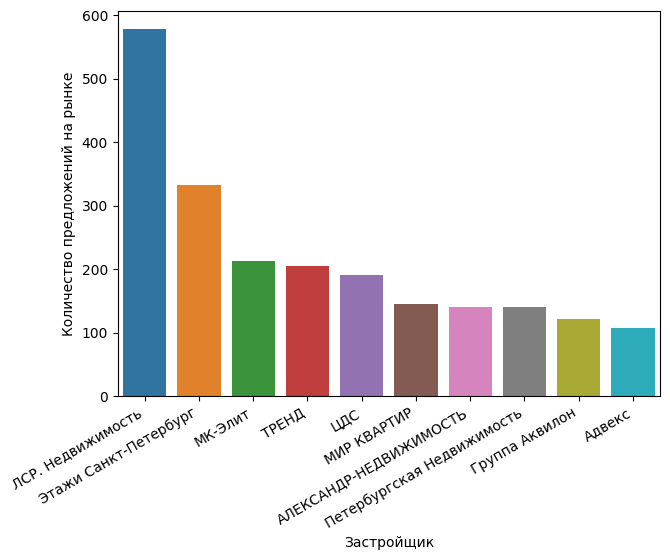

In [40]:
plt.figure(figsize=(7,5))
sns.barplot(x = developers_top10.index, y =developers_top10)
plt.ylabel('Количество предложений на рынке')
plt.xlabel('Застройщик')
plt.xticks(rotation = 30,ha='right');